In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import time as pctime

In [2]:
nomiregioni       = np.array(['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna',
                              'Friuli Venezia Giulia','Lazio','Liguria','Lombardia','Marche','Molise','Piemonte',
                              'Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto'])



pop_regioni   =  np.array([1304970, 559084,533050, 1947131, 5801692, 4459477, 1215220, 5879082, 1550640, 10060574, 1525271, 305617, 4356406, 4029053, 1639591, 4999891, 3729641,541380, 882015, 125666, 4905854])


df_popregioni=pd.DataFrame(pop_regioni)
df_popregioni.index=nomiregioni
df_popregioni.columns=['Popolazione']

df_popregioni

,Popolazione
Abruzzo,1304970
Basilicata,559084
P.A. Bolzano,533050
Calabria,1947131
Campania,5801692
Emilia-Romagna,4459477
Friuli Venezia Giulia,1215220
Lazio,5879082
Liguria,1550640
Lombardia,10060574


In [3]:
nome_regione=input('Scegli la regione: ')

popolazione_regione=df_popregioni.loc[str(nome_regione),'Popolazione']

print(popolazione_regione)

Scegli la regione: Molise
305617


# load national data

In [15]:
# dati cumulativi

datatot = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
mask = datatot['denominazione_regione']==nome_regione
data =datatot.loc[mask,:]

xdata=pd.to_numeric(range(data.shape[0]))
ydata=np.array(data['totale_casi'])
ydata_death=np.array(data['deceduti'])
ydata_rec=np.array(data['dimessi_guariti'])

ydata_inf=np.array(ydata-ydata_rec-ydata_death)

# i dati iniziano all'ottavo giorno. Prima non ci sono contagi
delay=0
ydata=ydata[delay:]
ydata_death=ydata_death[delay:]
ydata_rec=ydata_rec[delay:]
ydata_inf=ydata_inf[delay:]

print(data.iloc[-1,:])

data.head()

data                            2020-08-21T17:00:00
stato                                           ITA
codice_regione                                   14
denominazione_regione                        Molise
lat                                         41.5577
long                                        14.6592
ricoverati_con_sintomi                            1
terapia_intensiva                                 0
totale_ospedalizzati                              1
isolamento_domiciliare                           55
totale_positivi                                  56
variazione_totale_positivi                        1
nuovi_positivi                                    2
dimessi_guariti                                 430
deceduti                                         23
casi_da_sospetto_diagnostico                    498
casi_da_screening                                11
totale_casi                                     509
tamponi                                       30886
casi_testati

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
10,2020-02-24T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN
31,2020-02-25T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN
52,2020-02-26T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN
73,2020-02-27T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN
94,2020-02-28T18:00:00,ITA,14,Molise,41.557748,14.659161,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN


In [16]:
ydata_inf

array([  0,   0,   0,   0,   0,   0,   0,   0,   3,   3,   7,  12,  14,
        14,  14,  15,  16,  16,  17,  17,  17,  15,  19,  21,  38,  39,
        47,  52,  50,  55,  53,  81,  86,  98, 100, 107, 117, 131, 133,
       144, 171, 187, 187, 185, 181, 189, 193, 193, 202, 202, 200, 206,
       203, 208, 209, 215, 213, 213, 205, 198, 200, 198, 200, 200, 195,
       193, 190, 190, 182, 181, 178, 177, 179, 170, 184, 205, 218, 229,
       226, 231, 229, 227, 215, 216, 217, 212, 198, 194, 184, 189, 183,
       177, 174, 166, 163, 162, 156, 145, 135, 133, 127, 125, 122, 121,
       120, 119, 120, 120, 116, 114,  97,  74,  70,  65,  62,  60,  53,
        53,  40,  43,  43,  43,  36,  29,  26,  26,  26,  25,  25,  21,
        21,  21,  21,  21,  18,  17,  15,  15,  12,  13,  13,   9,   9,
         9,   8,   8,   8,   8,   8,  11,  17,  18,  21,  22,  25,  25,
        26,  26,  27,  29,  31,  33,  33,  34,  34,  35,  35,  35,  33,
        33,  29,  35,  35,  35,  35,  35,  44,  51,  55,  56])

In [32]:
ydata_terint=np.array(data['terapia_intensiva'])
ydata_ospedale=np.array(data['totale_ospedalizzati'])
ydata_tamponi=np.array(data['tamponi'])

positivi_giorn=np.diff(ydata)
tamponi_giorn=np.diff(ydata_tamponi)
ymorti=np.diff(ydata_death)

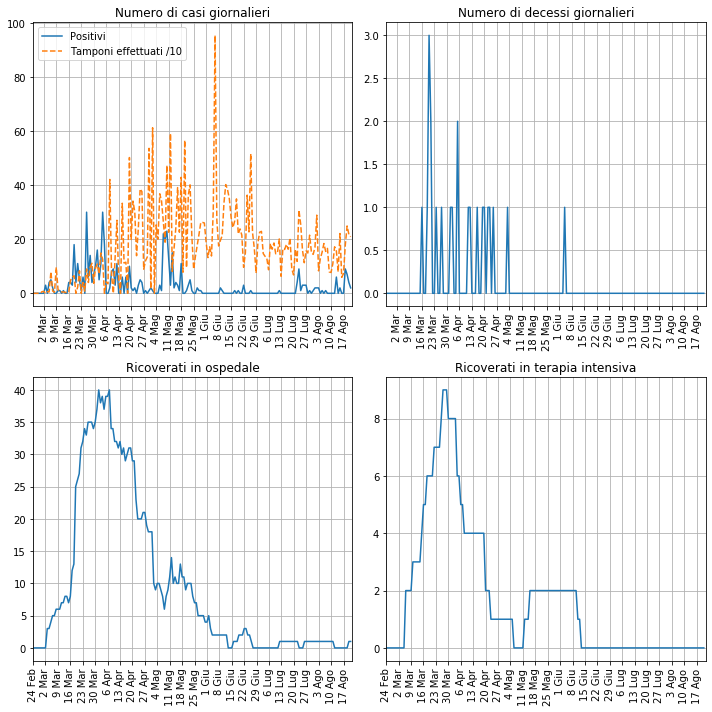

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(positivi_giorn,label='Positivi')
plt.plot(tamponi_giorn/10,label='Tamponi effettuati /10',linestyle='--')
#plt.plot(positivi_giorn[-15:]*100,label='2° ondata')
plt.xticks(np.arange(-1,200,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu','15 Giu','22 Giu','29 Giu','6 Lug','13 Lug','20 Lug','27 Lug','3 Ago','10 Ago','17 Ago','24 Ago'],rotation=90)
plt.xlim(0,len(positivi_giorn))
plt.title('Numero di casi giornalieri')
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.plot(ymorti)
#plt.plot(ymorti[-15:],label='2° ondata')
plt.title('Numero di decessi giornalieri')
plt.xticks(np.arange(-1,200,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu','15 Giu','22 Giu','29 Giu','6 Lug','13 Lug','20 Lug','27 Lug','3 Ago','10 Ago','17 Ago','24 Ago'],rotation=90)
plt.xlim(0,len(ymorti))
plt.grid()
plt.subplot(2,2,3)
plt.plot(ydata_ospedale)
#plt.plot(ydata_ospedale[-15:],label='2° ondata')
plt.xticks(np.arange(0,200,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu','15 Giu','22 Giu','29 Giu','6 Lug','13 Lug','20 Lug','27 Lug','3 Ago','10 Ago','17 Ago','24 Ago'],rotation=90)
plt.title('Ricoverati in ospedale')
plt.xlim(0,len(ydata_ospedale))
plt.grid()
plt.subplot(2,2,4)
plt.plot(ydata_terint)
#plt.plot(ydata_terint[-15:],label='2° ondata')
plt.xticks(np.arange(0,200,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu','15 Giu','22 Giu','29 Giu','6 Lug','13 Lug','20 Lug','27 Lug','3 Ago','10 Ago','17 Ago','24 Ago'],rotation=90)
plt.title('Ricoverati in terapia intensiva')
plt.xlim(0,len(ydata_terint))
plt.grid()
plt.tight_layout()
plt.savefig('output3/seconda_ondata_molise.png',dpi=300)
plt.show()

In [8]:
# dati differenziali

ydata_incr=[]
ydata_death_incr=[]
ydata_rec_incr=[]

for i in range(len(ydata)-1):
    ydata_incr.append(ydata[i+1]-ydata[i])
    ydata_death_incr.append(ydata_death[i+1]-ydata_death[i])
    ydata_rec_incr.append(ydata_rec[i+1]-ydata_rec[i])

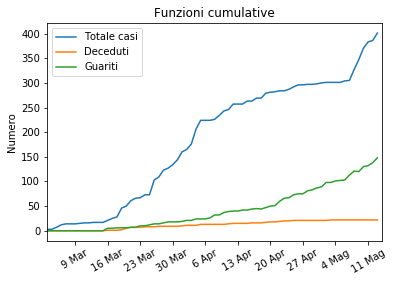

In [9]:
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti')
plt.xticks(np.arange(0-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Funzioni cumulative')
plt.legend()
plt.savefig('output3_regioni/dataonly.png')
plt.show()

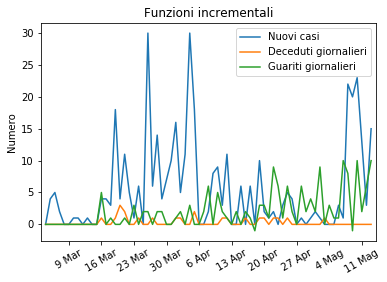

In [10]:
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Funzioni incrementali')
plt.legend()
plt.savefig('output3_regioni/dataonly_deriv.png')
plt.show()

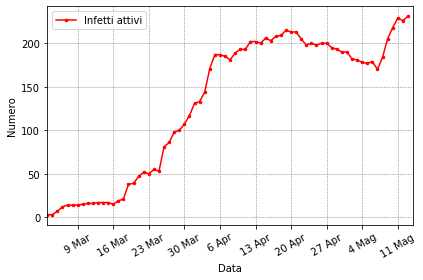

In [11]:
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',marker='.',markersize=5,label='Infetti attivi')
plt.xticks(np.arange(0-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
#plt.ylim(0,120000)
plt.xlabel('Data')
plt.ylabel('Numero')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('output3/sirdatacomp_prediction_dataonly.png',dpi=300)
plt.show()

# definition of the models

### definition of SIR 1.0

In [12]:
# The SIR model differential equations.
def deriv_SIR(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

def SIR(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### definition of SIR 2.0 

In [13]:
# The SIR model differential equations.
def deriv_SIR_2(y, t, N, beta1,gamma,tau=10**6,t_thresh=14):
    S,I,R = y
    
    if t<=t_thresh:      # il lockdown nazionale inizia al 14° giorno 
        B=beta1
    else: 
        B=beta1*np.exp(-(t-t_thresh)/tau)

    dSdt = -(B*I/N)*S 
    dIdt = (B*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt


def SIR_2(N,beta1,gamma,tau=10**6,t_thresh=14,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR_2, y0, t, args=(N,beta1,gamma,tau,t_thresh))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

# fitting the active infected

In [14]:
# 3 parameter fit for the active infected

def optimizer_adv(R0,tau,t_thresh):
    fin_result_updated=SIR_2(popolazione_regione,R0*1/14,1/14,tau,t_thresh,I0=ydata_inf[0])
    i_vec=fin_result_updated[2]
    
    pesi=np.exp(-np.arange(len(ydata_inf))/7)    # 
    pesi=pesi[::-1]
    
    accuracy=np.sum((ydata_inf-i_vec[0:len(ydata_inf)])**2/ydata_inf**2*pesi)   #mean squared error. This is used for the optimization
    
    errperc=np.mean(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    stdperc=np.std(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    
    return accuracy,errperc,stdperc

In [15]:
# grid on 3 parameters
R0grid=np.linspace(4,7,15)
taugrid=np.linspace(10,30,30)
ttreshgrid=np.linspace(0,10,10)

res_scan=[]
counter=0
counter2=0
cycle_tot=len(R0grid)*len(taugrid)*len(ttreshgrid)

time1=pctime.time()

# minimization

for r in R0grid:
    for tau in taugrid:
        for tt in ttreshgrid:
            opt_res=optimizer_adv(r,tau,tt)
            res_scan.append([r,tau,tt,opt_res[0],opt_res[1],opt_res[2]])
            counter=counter+1
            counter2=counter2+1
            if counter2==cycle_tot/10:
                time2=pctime.time()
                remtime=round((time2-time1)/counter*(cycle_tot-counter),1)
                print('completed ',round(counter/cycle_tot*100,1),'%. Remaining time ',remtime,'sec')
                counter2=0
        
res_scan=np.array(res_scan)

completed  10.0 %. Remaining time  13.1 sec
completed  20.0 %. Remaining time  12.7 sec
completed  30.0 %. Remaining time  11.6 sec
completed  40.0 %. Remaining time  9.9 sec
completed  50.0 %. Remaining time  8.6 sec
completed  60.0 %. Remaining time  6.9 sec
completed  70.0 %. Remaining time  5.1 sec
completed  80.0 %. Remaining time  3.3 sec
completed  90.0 %. Remaining time  1.7 sec
completed  100.0 %. Remaining time  0.0 sec


In [16]:
df_res_scan=pd.DataFrame(res_scan)
df_res_scan.columns=['R0','tau','t_thresh','MSE','mean err%','std err%']

df_res_scan.sort_values(by='MSE')

,R0,tau,t_thresh,MSE,mean err%,std err%
1190,4.642857,30.000000,0.000000,0.433626,39.134221,30.159806
593,4.214286,30.000000,3.333333,0.466020,42.798232,29.047016
285,4.000000,29.310345,5.555556,0.467486,42.153148,28.007835
583,4.214286,29.310345,3.333333,0.469251,36.740089,30.056160
891,4.428571,30.000000,1.111111,0.483186,32.059020,29.189646
...,...,...,...,...,...,...
4189,6.785714,29.310345,10.000000,379492.077433,21465.857506,14267.836101
4198,6.785714,30.000000,8.888889,381699.041220,19954.233118,13276.453890
4498,7.000000,30.000000,8.888889,382602.728091,22649.930528,14952.149665
3899,6.571429,30.000000,10.000000,387693.690844,19323.670494,13099.054481


In [17]:
par_ideal=np.array(df_res_scan.sort_values(by='MSE').iloc[0,0:])

par_ideal[0:3]

array([ 4.64285714, 30.        ,  0.        ])

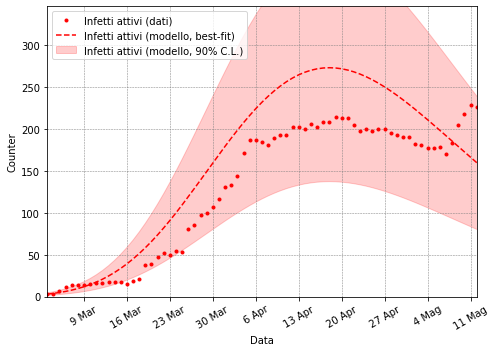

In [18]:
fin_result_updated=SIR_2(popolazione_regione,par_ideal[0]*1/14,1/14,par_ideal[1],t_thresh=par_ideal[2],I0=ydata_inf[0])

t=fin_result_updated[0]
i_vec=fin_result_updated[2]

plt.figure(figsize=(7,5))
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*1.65),i_vec*(1-par_ideal[5]/100*1.65), label='Infetti attivi (modello, 90% C.L.)',color='red',alpha=.2)
#plt.plot(np.zeros(2)+70,[-1000,140000],color='purple')
plt.xticks(np.arange(0-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu'],rotation=30)
plt.xlim(0,70)
plt.ylim(0,ydata_inf.max()*1.5)
#plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend(loc=2)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('output/fit_con_incertezza.png',dpi=300)
plt.show()  

In [19]:
i_vec[70]*(1+par_ideal[5]/100*2),i_vec[70]*(1-par_ideal[5]/100*2)

(256.5590542172961, 63.50041957647416)

In [20]:
#export

t_date=pd.to_datetime(t,unit='D',origin=pd.Timestamp('2020-02-24'))

export_v2 = pd.DataFrame({'date':t_date,'t':t, 'infetti best fit': i_vec,'infetti upper lim':i_vec*(1+par_ideal[5]/100*2),'infetti lower lim':i_vec*(1-par_ideal[5]/100*2)})
export_v2.to_csv('output3_regioni/nazionale_v2.csv',index=False)

# computation of national R0

### using data of last 5 days

1.85


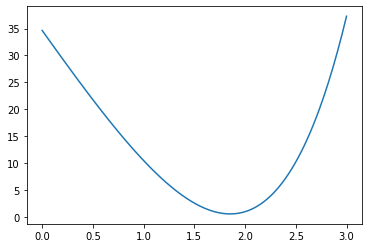

In [40]:
today=len(ydata_inf)

def minimizer(R0,t1=today-7,t2=today):
    
    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))
    
    #model
    fin_result=SIR(60*10**6,1/14*R0,1/14,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]
    
    #average error
    error=np.sum((ydata_inf_2-i_vec_2)**2/ydata_inf_2)/(len(ydata_inf_2)-1)
    
    return error

minimizer_vec=np.vectorize(minimizer)


#definition of the ideal r0

xgrid=np.linspace(0,3,200)
ygrid=minimizer_vec(xgrid)
r0_ideal=round(xgrid[np.argmin(ygrid)],2)
print(r0_ideal)

plt.plot(xgrid,ygrid)
plt.show()

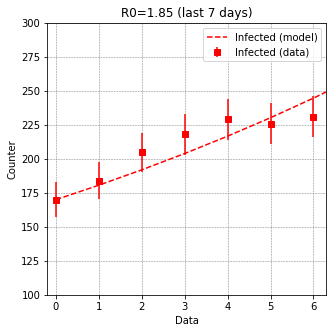

In [44]:
ydata_inf_2=np.array(ydata_inf[today-7:today])
xdata_2=np.arange(0,len(ydata_inf_2))

fin_result=SIR(60*10**6,1/14*r0_ideal,1/14,I0=ydata_inf_2[0])

t_R0=fin_result[0]
#s_vec=fin_result[1]
i_vec_R0=fin_result[2]
#r_vec=fin_result[3]

plt.figure(figsize=(5,5))
plt.errorbar(xdata_2,ydata_inf_2,np.sqrt(ydata_inf_2),color='red',linestyle='None',marker='s',label='Infected (data)')
plt.plot(t_R0, i_vec_R0, 'r--', label='Infected (model)')
#plt.yscale('log')
#plt.xticks(np.arange(14,70,7),['21 Feb','28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr'],rotation=30)
plt.xlim(-0.2,6.3)
plt.ylim(100,300)
#plt.ylim(0,300)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('R0='+str(r0_ideal)+' (last 7 days)')
plt.savefig('output3_regioni/r0-7days.png',dpi=300)
plt.show()

### scan of R0 over time

In [47]:
time_window=7

def minimizer_gen(t1,t2,xgrid=np.arange(0.1,5,0.01)):

    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]
scangrid=np.linspace(0.5,7,100)

for i in range(today-(time_window-1)):
    min_val=minimizer_gen(i,i+time_window,xgrid=scangrid)
    r0_time.append(min_val)
    scangrid=np.linspace(0.5,min_val+1,100)  #the grid change over the time (this speed up the process)
    print('Day n',i,' R0=',min_val)
    print(i,i+time_window,len((ydata_inf)))
    
r0_time=np.array(r0_time)

Day n 0  R0= 5.1
0 7 72
Day n 1  R0= 5.31
1 8 72
Day n 2  R0= 3.26
2 9 72
Day n 3  R0= 1.75
3 10 72
Day n 4  R0= 1.39
4 11 72
Day n 5  R0= 1.49
5 12 72
Day n 6  R0= 1.55
6 13 72
Day n 7  R0= 1.25
7 14 72
Day n 8  R0= 1.19
8 15 72
Day n 9  R0= 1.39
9 16 72
Day n 10  R0= 1.86
10 17 72
Day n 11  R0= 2.55
11 18 72
Day n 12  R0= 3.24
12 19 72
Day n 13  R0= 4.13
13 20 72
Day n 14  R0= 3.63
14 21 72
Day n 15  R0= 3.59
15 22 72
Day n 16  R0= 1.95
16 23 72
Day n 17  R0= 2.33
17 24 72
Day n 18  R0= 2.16
18 25 72
Day n 19  R0= 2.27
19 26 72
Day n 20  R0= 2.74
20 27 72
Day n 21  R0= 2.73
21 28 72
Day n 22  R0= 3.08
22 29 72
Day n 23  R0= 2.05
23 30 72
Day n 24  R0= 2.07
24 31 72
Day n 25  R0= 1.88
25 32 72
Day n 26  R0= 2.13
26 33 72
Day n 27  R0= 2.25
27 34 72
Day n 28  R0= 2.17
28 35 72
Day n 29  R0= 1.96
29 36 72
Day n 30  R0= 1.97
30 37 72
Day n 31  R0= 1.77
31 38 72
Day n 32  R0= 1.3
32 39 72
Day n 33  R0= 1.05
33 40 72
Day n 34  R0= 1.11
34 41 72
Day n 35  R0= 1.2
35 42 72
Day n 36  R0= 1.29

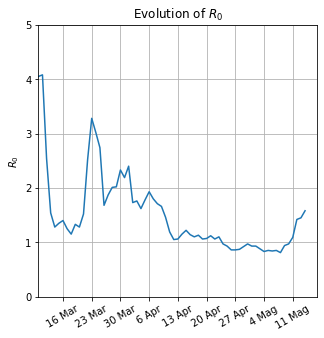

In [24]:
plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-delay-time_window,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid()
plt.title('Evolution of $R_0$')
#plt.savefig('output3/r0-evo.png',dpi=300)
plt.show()

In [25]:
# export R0 over time

df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time)),unit='D',origin='2020-02-28'))
df_r0['R0']=r0_time
df_r0.columns=['Data','R0']

df_r0.to_csv('output3_regioni/r0.csv',index=False)

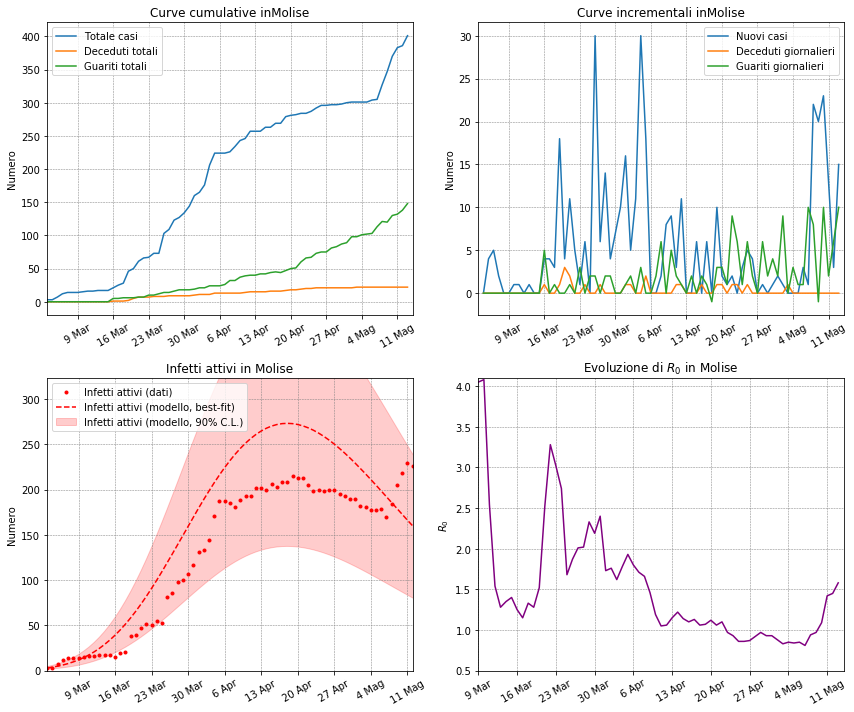

In [26]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti totali')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti totali')
plt.xticks(np.arange(0-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Curve cumulative in'+str(nome_regione))
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Curve incrementali in'+str(nome_regione))
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,3)
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*1.65),i_vec*(1-par_ideal[5]/100*1.65), label='Infetti attivi (modello, 90% C.L.)',color='red',alpha=.2)
#plt.plot(np.zeros(2)+70,[-1000,140000],color='purple')
plt.xticks(np.arange(0-delay,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu','8 Giu'],rotation=30)
plt.xlim(0,70)
plt.ylim(0,ydata_inf[-1]*1.4)
#plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
#plt.xlabel('Data')
plt.ylabel('Numero')
plt.legend(loc=2)
plt.title('Infetti attivi in '+str(nome_regione))
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,4)
plt.plot(r0_time,color='purple')
plt.xticks(np.arange(0-delay-time_window+1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,today-6)
plt.ylabel('$R_0$')
plt.ylim(0.5,4.1)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Evoluzione di $R_0$ in '+str(nome_regione))
plt.tight_layout()
plt.savefig('output3_regioni/4plots.png',dpi=300)

### future forecasting

In [27]:
# The SIR model differential equations.
def deriv_SIR_2_future(y, t, N, beta1,gamma,newR0,tau=10**6,t_thresh=14):
    S,I,R = y
    
    if t<=t_thresh:      # il lockdown nazionale inizia al 14° giorno 
        B=beta1
    elif t>t_thresh and t<=70-delay: 
        B=beta1*np.exp(-(t-t_thresh)/tau)
    elif t>70-delay:
        B=newR0*gamma
        #B=beta1*np.exp(-(70-t_thresh)/tau)+0.05*gamma*(t-70)
        #print(B,t)

    dSdt = -(B*I/N)*S 
    dIdt = (B*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt


def SIR_2_future(N,beta1,gamma,newR0,tau=10**6,t_thresh=14,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR_2_future, y0, t, args=(N,beta1,gamma,newR0,tau,t_thresh))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

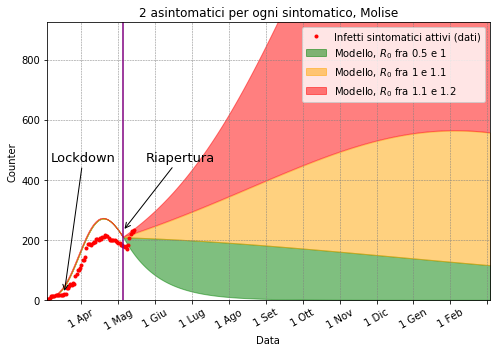

In [28]:
asympt=3

i_vec_future050=SIR_2_future(popolazione_regione,par_ideal[0]*1/14,1/14,0.5,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future100=SIR_2_future(popolazione_regione,par_ideal[0]*1/14,1/14,1.0,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future110=SIR_2_future(popolazione_regione,par_ideal[0]*1/14,1/14,1.1,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future115=SIR_2_future(popolazione_regione,par_ideal[0]*1/14,1/14,1.15,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]
i_vec_future120=SIR_2_future(popolazione_regione,par_ideal[0]*1/14,1/14,1.20,par_ideal[1],t_thresh=par_ideal[2],I0=asympt*ydata_inf[0])[2]

plt.figure(figsize=(7,5))
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti sintomatici attivi (dati)')
plt.fill_between(t, i_vec_future100/asympt,i_vec_future050/asympt,color='green',label='Modello, $R_0$ fra 0.5 e 1',alpha=0.5)
plt.fill_between(t, i_vec_future110/asympt,i_vec_future100/asympt,color='orange',label='Modello, $R_0$ fra 1 e 1.1',alpha=0.5)
plt.fill_between(t, i_vec_future120/asympt,i_vec_future110/asympt,color='red',label='Modello, $R_0$ fra 1.1 e 1.2',alpha=0.5)
#plt.plot(t, i_vec_future05/asympt, label='Modello, R$_0^{riapertura}$=0.5')
#plt.plot(t, i_vec_future10/asympt, label='Modello, R$_0^{riapertura}$=1')
#plt.plot(t, i_vec_future15/asympt, label='Modello, R$_0^{riapertura}$=1.1')
#plt.plot(t, i_vec_future20/asympt, label='Modello, R$_0^{riapertura}$=1.2')
#plt.fill_between(t, i_vec_future*(1+par_ideal[4]/100*2)/asympt,i_vec_future*(1-par_ideal[4]/100*2)/asympt, label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70-delay,[-1000,10**7],color='purple')
plt.xticks(np.arange(6-delay,361,30),['1 Mar','1 Apr','1 Mag','1 Giu','1 Lug','1 Ago','1 Set','1 Ott','1 Nov','1 Dic','1 Gen','1 Feb'],rotation=30)
plt.xlim(0,360)
plt.ylim(0,ydata_inf.max()*4)
#plt.ylim(10000,ydata_inf[-1]*1.4)
#plt.ylim(100,10**7)
#plt.yscale('log')
plt.annotate("Lockdown", xy=(14,ydata_inf.max()/10), xytext=(3,ydata_inf.max()*2), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.annotate("Riapertura", xy=(70-delay,ydata_inf.max()), xytext=(80,ydata_inf.max()*2), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('2 asintomatici per ogni sintomatico, '+str(nome_regione))
plt.tight_layout()
plt.savefig('output3/predizioni_future'+str(nome_regione)+'.png',dpi=300)
plt.show()